In [ ]:
!pip install sentence_transformers

In [24]:
from google.colab import drive
drive.mount('/content/drive')
import os

def get_image_paths():
  image_dir = '/content/drive/My Drive/datasets/iPhone/'

  # List all files in the directory
  image_paths = []
  for root, dirs, files in os.walk(image_dir):
    for file in files:
      if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
        image_paths.append(os.path.join(root, file))
  return image_paths

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import os
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt



# CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", from_tf=True).to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Image preprocessing
image_transform = Compose([
    Resize(224, interpolation=Image.BICUBIC),
    CenterCrop(224),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def embed_image(image_path):
    image = Image.open(image_path)
    inputs = image_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.get_image_features(pixel_values=inputs)
    return image_features

def embed_text(description):
    inputs = processor(text=description, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features

All TF 2.0 model weights were used when initializing CLIPModel.

All the weights of CLIPModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use CLIPModel for predictions without further training.


Enter an image description: a very fluffy animal


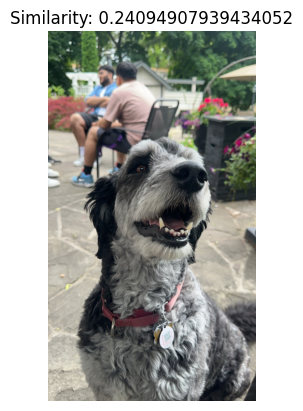

In [32]:
image_paths = get_image_paths()
description = input("Enter an image description: ")

text_embedding = embed_text(description).cpu().numpy()

# Find most similar match
max_similarity = -1
most_similar_image_path = None
for image_path in image_paths:
    image_embedding = embed_image(image_path).cpu().numpy()
    similarity = cosine_similarity(image_embedding, text_embedding)[0][0]
    if similarity > max_similarity:
        max_similarity = similarity
        most_similar_image_path = image_path

# Display most similar match
most_similar_image = Image.open(most_similar_image_path)
plt.imshow(most_similar_image)
plt.title(f"Similarity: {max_similarity}")
plt.axis('off')
plt.show()